In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install allennlp

In [3]:
import os
import random
import time
import datetime
import json
import pandas as pd
import numpy as np
import torch
import pickle
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import f1_score
import copy

In [4]:
# Load the config file
def load_config(config_path):
    # Load and parse the config file
    with open(config_path, 'r') as f:
        config = json.load(f)

    return config

#config = load_config('./HBiLSTM_CL.json')

In [5]:
from data import SequenceClassificationDataset

In [6]:
root = '/content/'
it_train_dataset = SequenceClassificationDataset(Path(root,'train_transformerd_IT.json'))
it_dev_dataset = SequenceClassificationDataset(Path(root, 'dev_transformerd_IT.json'))
it_test_dataset = SequenceClassificationDataset(Path(root, 'test_transformerd_IT.json'))

In [7]:
len(it_train_dataset), len(it_dev_dataset), len(it_test_dataset)

(40, 5, 5)

In [8]:
batch_size=1
train_dataloader = DataLoader(it_train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(it_dev_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(it_test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
from models import BertHSLN

In [10]:
BERT_MODEL = "bert-base-uncased"
mconfig = {
    "bert_model": BERT_MODEL,
    "bert_trainable": False,
    "model": BertHSLN.__name__,
    "cacheable_tasks": [],

    "dropout": 0.5,
    "word_lstm_hs": 384,
    "att_pooling_dim_ctx": 50,
    "att_pooling_num_ctx": 7,

    "lr": 3e-05,
    "lr_epoch_decay": 0.9,
    "batch_size":  32,
    "max_seq_length": 120,
    "max_epochs": 20,
    "early_stopping": 20,

}

In [11]:
torch.cuda.is_available()

True

In [12]:
# assign device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device used: {device}")

device used: cuda


In [13]:
model = BertHSLN(mconfig, num_labels = 7)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Attention pooling dim: 5376


In [14]:
seed_val = 42
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [15]:
# assign device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device used: {device}")
model.to(device)

device used: cuda


BertHSLN(
  (bert): BertTokenEmbedder(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
               

In [16]:
import functools
import operator

In [17]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

21290135

In [18]:
sum(p.numel() for p in model.parameters() if p.requires_grad) / 11852751

1.7962188693578394

In [19]:
from torch.optim.lr_scheduler import StepLR
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=mconfig['lr'])
epoch_scheduler = StepLR(optimizer, step_size=1, gamma=mconfig["lr_epoch_decay"])


In [20]:
from train import training_step, validation_step
train_epoch_losses = {'cls':[]}
train_epoch_acc = []
train_epoch_f1 = []

dev_epoch_losses = []
dev_epoch_acc = []
dev_epoch_f1 = []


best_dev_f1 = 0
best_model = None

epochs = 40

In [21]:
# Training loop
for epoch in range(epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))

    # Training
    train_loss = training_step(model, optimizer, epoch_scheduler, train_dataloader, device)
    train_epoch_losses['cls'].append(train_loss['cls'])
    print(f"Epoch {epoch+1}/{epochs} - Training CLS Loss: {train_loss['cls']:.4f}")

    # Validation
    dev_f1, dev_loss = validation_step(model, valid_dataloader, device)
    dev_epoch_losses.append(dev_loss)
    dev_epoch_f1.append(dev_f1)
    print(f"Epoch {epoch+1}/{epochs} - dev loss {dev_loss} - F1 {dev_f1}")

    if dev_f1 > best_dev_f1:
        best_dev_f1 = dev_f1
        best_model = copy.deepcopy(model)
        print(f'saving the checkpoint with dev f1 - {best_dev_f1}')

======== Epoch 1 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.959177851676941
after 10 step: cls_loss 1.8233356475830078
after 20 step: cls_loss 1.6303014755249023
after 30 step: cls_loss 1.9918243885040283
Epoch 1/40 - Training CLS Loss: 1.8439
Epoch 1/40 - dev loss 1.7126857042312622 - F1 0.13890881808163935
saving the checkpoint with dev f1 - 0.13890881808163935
======== Epoch 2 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.6138449907302856
after 10 step: cls_loss 2.0823512077331543
after 20 step: cls_loss 2.0021283626556396
after 30 step: cls_loss 1.7324342727661133
Epoch 2/40 - Training CLS Loss: 1.7430
Epoch 2/40 - dev loss 1.600532865524292 - F1 0.15809663249272762
saving the checkpoint with dev f1 - 0.15809663249272762
======== Epoch 3 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.6866647005081177
after 10 step: cls_loss 1.7813323736190796
after 20 step: cls_loss 1.765267252922058
after 30 step: cls_loss 1.2972681522369385
Epoch 3/40 - Training CLS Loss: 1.6467
Epoch 3/40 - dev loss 1.47918701171875 - F1 0.1865161785104456
saving the checkpoint with dev f1 - 0.1865161785104456
======== Epoch 4 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.531301736831665
after 10 step: cls_loss 1.6313730478286743
after 20 step: cls_loss 1.5100995302200317
after 30 step: cls_loss 1.6201496124267578
Epoch 4/40 - Training CLS Loss: 1.5132
Epoch 4/40 - dev loss 1.3752891302108765 - F1 0.24642050453082984
saving the checkpoint with dev f1 - 0.24642050453082984
======== Epoch 5 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.613555908203125
after 10 step: cls_loss 1.4404388666152954
after 20 step: cls_loss 1.372452974319458
after 30 step: cls_loss 1.3123960494995117
Epoch 5/40 - Training CLS Loss: 1.4060
Epoch 5/40 - dev loss 1.3741862297058105 - F1 0.2360472548841858
======== Epoch 6 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.3612481355667114
after 10 step: cls_loss 1.4109246730804443
after 20 step: cls_loss 1.1577593088150024
after 30 step: cls_loss 1.2562392950057983
Epoch 6/40 - Training CLS Loss: 1.3468
Epoch 6/40 - dev loss 1.3496888875961304 - F1 0.3215803163320222
saving the checkpoint with dev f1 - 0.3215803163320222
======== Epoch 7 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.3297821283340454
after 10 step: cls_loss 1.3994159698486328
after 20 step: cls_loss 1.131261944770813
after 30 step: cls_loss 1.1802927255630493
Epoch 7/40 - Training CLS Loss: 1.2928
Epoch 7/40 - dev loss 1.2557225346565246 - F1 0.3533723958594697
saving the checkpoint with dev f1 - 0.3533723958594697
======== Epoch 8 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.2527905702590942
after 10 step: cls_loss 1.4631152153015137
after 20 step: cls_loss 0.9949104189872742
after 30 step: cls_loss 1.533362627029419
Epoch 8/40 - Training CLS Loss: 1.2633
Epoch 8/40 - dev loss 1.2696234226226806 - F1 0.33525049462702683
======== Epoch 9 / 40 ========
after 0 step: cls_loss 1.2961887121200562


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 10 step: cls_loss 1.1361531019210815
after 20 step: cls_loss 1.3936686515808105
after 30 step: cls_loss 0.9463837742805481
Epoch 9/40 - Training CLS Loss: 1.2342
Epoch 9/40 - dev loss 1.2410402178764344 - F1 0.35731559318852685
saving the checkpoint with dev f1 - 0.35731559318852685
======== Epoch 10 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.1746176481246948
after 10 step: cls_loss 0.8266977667808533
after 20 step: cls_loss 1.442262887954712
after 30 step: cls_loss 1.4380954504013062
Epoch 10/40 - Training CLS Loss: 1.2019
Epoch 10/40 - dev loss 1.23963862657547 - F1 0.35269838768420836
======== Epoch 11 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.0248209238052368
after 10 step: cls_loss 0.7126891613006592
after 20 step: cls_loss 1.3149784803390503
after 30 step: cls_loss 1.3347361087799072
Epoch 11/40 - Training CLS Loss: 1.1855
Epoch 11/40 - dev loss 1.2872453212738038 - F1 0.37203683232837587
saving the checkpoint with dev f1 - 0.37203683232837587
======== Epoch 12 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 2.0584664344787598
after 10 step: cls_loss 0.8097988963127136
after 20 step: cls_loss 1.3836246728897095
after 30 step: cls_loss 1.1801913976669312
Epoch 12/40 - Training CLS Loss: 1.1774
Epoch 12/40 - dev loss 1.2561786770820618 - F1 0.3653588691086402
======== Epoch 13 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.9576095342636108
after 10 step: cls_loss 1.1180603504180908
after 20 step: cls_loss 1.2703273296356201
after 30 step: cls_loss 0.9914875030517578
Epoch 13/40 - Training CLS Loss: 1.1617
Epoch 13/40 - dev loss 1.2765909552574157 - F1 0.3427468038751786
======== Epoch 14 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.8311924934387207
after 10 step: cls_loss 1.435662865638733
after 20 step: cls_loss 1.064104437828064
after 30 step: cls_loss 1.2734216451644897
Epoch 14/40 - Training CLS Loss: 1.1420
Epoch 14/40 - dev loss 1.2618952512741088 - F1 0.36684588706630666
======== Epoch 15 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.3329418897628784
after 10 step: cls_loss 1.3422701358795166
after 20 step: cls_loss 0.987680971622467
after 30 step: cls_loss 0.8091616034507751
Epoch 15/40 - Training CLS Loss: 1.1308
Epoch 15/40 - dev loss 1.2599404335021973 - F1 0.37604853491796597
saving the checkpoint with dev f1 - 0.37604853491796597
======== Epoch 16 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.790114164352417
after 10 step: cls_loss 0.939027726650238
after 20 step: cls_loss 0.5997663140296936
after 30 step: cls_loss 1.1360262632369995
Epoch 16/40 - Training CLS Loss: 1.1297
Epoch 16/40 - dev loss 1.277845823764801 - F1 0.3811911594895557
saving the checkpoint with dev f1 - 0.3811911594895557
======== Epoch 17 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.33818781375885
after 10 step: cls_loss 1.0560917854309082
after 20 step: cls_loss 0.9930168986320496
after 30 step: cls_loss 0.8011596202850342
Epoch 17/40 - Training CLS Loss: 1.1173
Epoch 17/40 - dev loss 1.2865774512290955 - F1 0.3749155526639121
======== Epoch 18 / 40 ========
after 0 step: cls_loss 0.9408887028694153


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 10 step: cls_loss 0.7396976351737976
after 20 step: cls_loss 1.1093424558639526
after 30 step: cls_loss 1.3581820726394653
Epoch 18/40 - Training CLS Loss: 1.1034
Epoch 18/40 - dev loss 1.2978059649467468 - F1 0.3739222849613238
======== Epoch 19 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.3198779821395874
after 10 step: cls_loss 1.1389899253845215
after 20 step: cls_loss 1.2955915927886963
after 30 step: cls_loss 1.0747957229614258
Epoch 19/40 - Training CLS Loss: 1.0978
Epoch 19/40 - dev loss 1.2896689295768737 - F1 0.38160422079563233
saving the checkpoint with dev f1 - 0.38160422079563233
======== Epoch 20 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.237067461013794
after 10 step: cls_loss 1.0218069553375244
after 20 step: cls_loss 0.8412553071975708
after 30 step: cls_loss 1.4468168020248413
Epoch 20/40 - Training CLS Loss: 1.0927
Epoch 20/40 - dev loss 1.2967119097709656 - F1 0.3813643031912755
======== Epoch 21 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.451048493385315
after 10 step: cls_loss 1.8137266635894775
after 20 step: cls_loss 1.1813069581985474
after 30 step: cls_loss 1.1047539710998535
Epoch 21/40 - Training CLS Loss: 1.0839
Epoch 21/40 - dev loss 1.2980111241340637 - F1 0.3795632757122926
======== Epoch 22 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.2429693937301636
after 10 step: cls_loss 1.3598686456680298
after 20 step: cls_loss 0.8170491456985474
after 30 step: cls_loss 0.866319477558136
Epoch 22/40 - Training CLS Loss: 1.0730
Epoch 22/40 - dev loss 1.3110720276832581 - F1 0.3866743059525421
saving the checkpoint with dev f1 - 0.3866743059525421
======== Epoch 23 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.7670164704322815
after 10 step: cls_loss 1.0314472913742065
after 20 step: cls_loss 1.2542273998260498
after 30 step: cls_loss 1.021437406539917
Epoch 23/40 - Training CLS Loss: 1.0747
Epoch 23/40 - dev loss 1.3113529920578002 - F1 0.39183823633118425
saving the checkpoint with dev f1 - 0.39183823633118425
======== Epoch 24 / 40 ========
after 0 step: cls_loss 1.1325554847717285


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 10 step: cls_loss 1.3830013275146484
after 20 step: cls_loss 1.3901152610778809
after 30 step: cls_loss 0.7613413333892822
Epoch 24/40 - Training CLS Loss: 1.0652
Epoch 24/40 - dev loss 1.3084349632263184 - F1 0.378569827654891
======== Epoch 25 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.060971736907959
after 10 step: cls_loss 1.7007993459701538
after 20 step: cls_loss 0.9215572476387024
after 30 step: cls_loss 0.7518432140350342
Epoch 25/40 - Training CLS Loss: 1.0728
Epoch 25/40 - dev loss 1.3117478132247924 - F1 0.40065764110350505
saving the checkpoint with dev f1 - 0.40065764110350505
======== Epoch 26 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.0256242752075195
after 10 step: cls_loss 0.7378301024436951
after 20 step: cls_loss 1.0436275005340576
after 30 step: cls_loss 0.6720881462097168
Epoch 26/40 - Training CLS Loss: 1.0587
Epoch 26/40 - dev loss 1.3156281113624573 - F1 0.4071713454763361
saving the checkpoint with dev f1 - 0.4071713454763361
======== Epoch 27 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.1889219284057617
after 10 step: cls_loss 1.028610110282898
after 20 step: cls_loss 0.6851491332054138
after 30 step: cls_loss 0.7860613465309143
Epoch 27/40 - Training CLS Loss: 1.0576
Epoch 27/40 - dev loss 1.313954734802246 - F1 0.3924677832590282
======== Epoch 28 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.1032718420028687
after 10 step: cls_loss 0.8086445927619934
after 20 step: cls_loss 0.860958993434906
after 30 step: cls_loss 1.0718001127243042
Epoch 28/40 - Training CLS Loss: 1.0626
Epoch 28/40 - dev loss 1.3136675238609314 - F1 0.4064597330986405
======== Epoch 29 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.2764452695846558
after 10 step: cls_loss 0.8837822079658508
after 20 step: cls_loss 1.2615032196044922
after 30 step: cls_loss 0.9324096441268921
Epoch 29/40 - Training CLS Loss: 1.0546
Epoch 29/40 - dev loss 1.320417845249176 - F1 0.3994227607218991
======== Epoch 30 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.5743796825408936
after 10 step: cls_loss 2.1031556129455566
after 20 step: cls_loss 1.0792959928512573
after 30 step: cls_loss 0.9199250936508179
Epoch 30/40 - Training CLS Loss: 1.0522
Epoch 30/40 - dev loss 1.3164301872253419 - F1 0.4014947666444072
======== Epoch 31 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.7838211059570312
after 10 step: cls_loss 0.5858607292175293
after 20 step: cls_loss 1.1453744173049927
after 30 step: cls_loss 1.2301687002182007
Epoch 31/40 - Training CLS Loss: 1.0545
Epoch 31/40 - dev loss 1.3221969604492188 - F1 0.40403952345126687
======== Epoch 32 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.5915434956550598
after 10 step: cls_loss 0.7083399295806885
after 20 step: cls_loss 0.8932314515113831
after 30 step: cls_loss 0.9084610939025879
Epoch 32/40 - Training CLS Loss: 1.0460
Epoch 32/40 - dev loss 1.3181996822357178 - F1 0.4043321351649069
======== Epoch 33 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.2126444578170776
after 10 step: cls_loss 0.984039306640625
after 20 step: cls_loss 0.6998288631439209
after 30 step: cls_loss 2.0896828174591064
Epoch 33/40 - Training CLS Loss: 1.0469
Epoch 33/40 - dev loss 1.3169042229652406 - F1 0.40056393671952134
======== Epoch 34 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.2488590478897095
after 10 step: cls_loss 1.2209782600402832
after 20 step: cls_loss 0.7274805903434753
after 30 step: cls_loss 1.2027721405029297
Epoch 34/40 - Training CLS Loss: 1.0503
Epoch 34/40 - dev loss 1.321855628490448 - F1 0.40482518564448544
======== Epoch 35 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.4020733833312988
after 10 step: cls_loss 1.1051768064498901
after 20 step: cls_loss 0.7850099205970764
after 30 step: cls_loss 1.4600111246109009
Epoch 35/40 - Training CLS Loss: 1.0471
Epoch 35/40 - dev loss 1.3217366099357606 - F1 0.3999152505657671
======== Epoch 36 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.2677687406539917
after 10 step: cls_loss 0.9957228899002075
after 20 step: cls_loss 1.4109020233154297
after 30 step: cls_loss 1.413102626800537
Epoch 36/40 - Training CLS Loss: 1.0486
Epoch 36/40 - dev loss 1.3222641587257384 - F1 0.4036292104685475
======== Epoch 37 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 1.064442753791809
after 10 step: cls_loss 1.2353538274765015
after 20 step: cls_loss 1.1898268461227417
after 30 step: cls_loss 0.8936604261398315
Epoch 37/40 - Training CLS Loss: 1.0445
Epoch 37/40 - dev loss 1.3207677721977233 - F1 0.4028472066317862
======== Epoch 38 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.564639687538147
after 10 step: cls_loss 0.8503987789154053
after 20 step: cls_loss 1.6735516786575317
after 30 step: cls_loss 0.9411623477935791
Epoch 38/40 - Training CLS Loss: 1.0414
Epoch 38/40 - dev loss 1.3198723912239074 - F1 0.41263395307181605
saving the checkpoint with dev f1 - 0.41263395307181605
======== Epoch 39 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.9478142857551575
after 10 step: cls_loss 0.8778303265571594
after 20 step: cls_loss 1.2235527038574219
after 30 step: cls_loss 0.9208464026451111
Epoch 39/40 - Training CLS Loss: 1.0462
Epoch 39/40 - dev loss 1.3213935852050782 - F1 0.405608983510826
======== Epoch 40 / 40 ========


/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


after 0 step: cls_loss 0.9427142143249512
after 10 step: cls_loss 1.36911940574646
after 20 step: cls_loss 0.9697318077087402
after 30 step: cls_loss 0.8914898037910461
Epoch 40/40 - Training CLS Loss: 1.0411
Epoch 40/40 - dev loss 1.3213535308837892 - F1 0.4126592818123978
saving the checkpoint with dev f1 - 0.4126592818123978


In [23]:
dev_epoch_f1

[0.13890881808163935,
 0.15809663249272762,
 0.1865161785104456,
 0.24642050453082984,
 0.2360472548841858,
 0.3215803163320222,
 0.3533723958594697,
 0.33525049462702683,
 0.35731559318852685,
 0.35269838768420836,
 0.37203683232837587,
 0.3653588691086402,
 0.3427468038751786,
 0.36684588706630666,
 0.37604853491796597,
 0.3811911594895557,
 0.3749155526639121,
 0.3739222849613238,
 0.38160422079563233,
 0.3813643031912755,
 0.3795632757122926,
 0.3866743059525421,
 0.39183823633118425,
 0.378569827654891,
 0.40065764110350505,
 0.4071713454763361,
 0.3924677832590282,
 0.4064597330986405,
 0.3994227607218991,
 0.4014947666444072,
 0.40403952345126687,
 0.4043321351649069,
 0.40056393671952134,
 0.40482518564448544,
 0.3999152505657671,
 0.4036292104685475,
 0.4028472066317862,
 0.41263395307181605,
 0.405608983510826,
 0.4126592818123978]

[0.13890881808163935,
 0.15809663249272762,
 0.1865161785104456,
 0.24642050453082984,
 0.2360472548841858,
 0.3215803163320222,
 0.3533723958594697,
 0.33525049462702683,
 0.35731559318852685,
 0.35269838768420836,
 0.37203683232837587,
 0.3653588691086402,
 0.3427468038751786,
 0.36684588706630666,
 0.37604853491796597,
 0.3811911594895557,
 0.3749155526639121,
 0.3739222849613238,
 0.38160422079563233,
 0.3813643031912755,
 0.3795632757122926,
 0.3866743059525421,
 0.39183823633118425,
 0.378569827654891,
 0.40065764110350505,
 0.4071713454763361,
 0.3924677832590282,
 0.4064597330986405,
 0.3994227607218991,
 0.4014947666444072,
 0.40403952345126687,
 0.4043321351649069,
 0.40056393671952134,
 0.40482518564448544,
 0.3999152505657671,
 0.4036292104685475,
 0.4028472066317862,
 0.41263395307181605,
 0.405608983510826,
 0.4126592818123978]

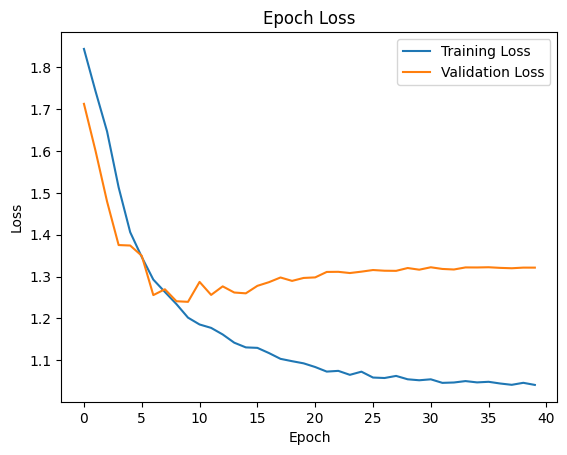

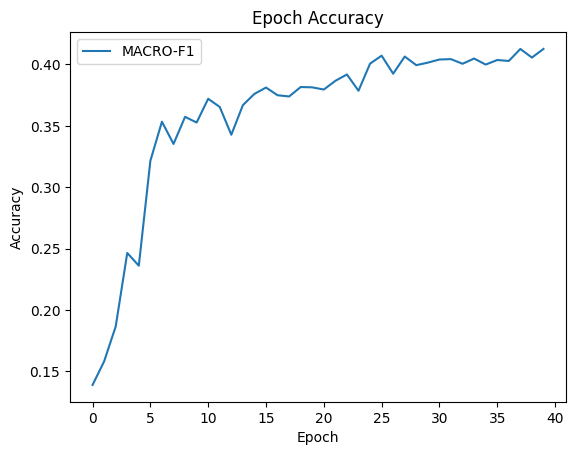

In [25]:
import matplotlib.pyplot as plt

# Plot the epoch loss
plt.plot(train_epoch_losses['cls'], label='Training Loss')
plt.plot(dev_epoch_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Epoch Loss')
plt.show()

# Plot the epoch accuracies
#plt.plot(train_epoch_acc, label='Training acc')
plt.plot(dev_epoch_f1, label='MACRO-F1')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Epoch Accuracy')
plt.show()

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [29]:
from train import testing_step

In [34]:
test_loss, test_accuracy, predictions, true_labels = testing_step(best_model, valid_dataloader, device)

/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Testing Loss: 0.0000 - Testing Accuracy: 71.8000
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       207
           1       0.20      0.20      0.20        92
           2       0.50      0.36      0.42       162
           3       0.33      0.67      0.44       115
           4       0.00      0.00      0.00        46
           5       1.00      0.26      0.41        31
           6       0.87      0.53      0.66        62

    accuracy                           0.50       715
   macro avg       0.52      0.40      0.41       715
weighted avg       0.52      0.50      0.49       715



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
# Testing loop
test_loss, test_accuracy, predictions, true_labels = testing_step(best_model, test_dataloader, device)

/content/train.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result[k] = torch.tensor(v)


Testing Loss: 0.0000 - Testing Accuracy: 91.2000
              precision    recall  f1-score   support

           0       0.65      0.84      0.73       145
           1       0.53      0.37      0.43       115
           2       0.71      0.41      0.52       145
           3       0.45      0.76      0.57       191
           4       1.00      0.01      0.02        99
           5       1.00      0.12      0.21        25
           6       0.54      0.71      0.61       115

    accuracy                           0.55       835
   macro avg       0.70      0.46      0.44       835
weighted avg       0.63      0.55      0.50       835

Macro F1-score: 44.25
Micro F1-score: 54.61
Weighted F1-score: 49.96


In [42]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
import torch

def save_model_state_dict(model, filepath):
    """
    Save the model's state dictionary to a file.

    Parameters:
        model (torch.nn.Module): The PyTorch model to save.
        filepath (str): The file path where the model will be saved.
    """
    torch.save(model.state_dict(), filepath)
    print(f"Model state_dict saved to {filepath}")


In [43]:
save_model_state_dict(best_model, "/content/drive/MyDrive/OS/baseline_malik_it.pth")

Model state_dict saved to /content/drive/MyDrive/OS/baseline_malik_it.pth
